In [ ]:
# =================== CONNECT TO GOOGLE DRIVE ===========================

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# ==========================================================================
#                     BASE PAPER IMPLEMENTATION
# ==========================================================================

# ==========================================================================
#                     GRAPH CONSTRUCTION
# ==========================================================================


In [ ]:
# -------------  FLOW CLASSIFICATION  ------------------

In [2]:
import csv
from decimal import Decimal


def prepare_dataset(file_path):
    packets = []
    with open(file_path, 'r') as file:
        reader = csv.DictReader(file)
        for row in reader:
            flow_id = f"{row['Source']}-{row['Destination']}-{row['Protocol']}"
            #print("RAW TIME = ", row['Time'], "Type: ", type(row['Time']))
            time_float = float(row['Time'])
            #print("CHANGED TIME TO FLOAT = ", time_float, "Type: ", type(time_float))
            # Format as a string for display purposes
            #time_fixed = f"{time_float:.6f}"
            #print("FORCED DECIMAL FORMAT AS STRING = ", time_fixed, "Type: ", type(time_fixed))
            # Store float but format it only when printing
            packets.append({
                "time": time_float,  # Keep as float
                "flow_id": flow_id,
                "length": int(row["Length"]),
                "info": row["Info"]
            })
    return packets

def secure_flow_classification(PktInfo, JUDGE_INTERVAL, PKT_TIMEOUT, FLOW_LINE):
    FlowHashTable = {}
    ShortFlow = []
    LongFlow = []

    time_now = PktInfo[0]["time"]
    last_check = time_now

    for pkt in PktInfo:
        time_now = pkt["time"]

        flow_id = pkt["flow_id"]
        if flow_id not in FlowHashTable:
            FlowHashTable[flow_id] = []
        FlowHashTable[flow_id].append(pkt)
        #print("time_now:", time_now, type(time_now))
        #print("last_check:", last_check, type(last_check))
        if time_now - last_check > JUDGE_INTERVAL:
            for flow_id, flow in list(FlowHashTable.items()):
                if time_now - flow[-1]["time"] > PKT_TIMEOUT:
                    if len(flow) < FLOW_LINE:
                        ShortFlow.append(flow)
                    else:
                        LongFlow.append(flow)
                    del FlowHashTable[flow_id]
            last_check = time_now


    return ShortFlow, LongFlow

# Load the dataset
file_path = "/content/drive/My Drive/data_5.csv"  # Replace with your dataset's file path
PktInfo = prepare_dataset(file_path)


#print("Packets: \n")
#print(PktInfo)

# Parameters for the algorithm
JUDGE_INTERVAL = 0.01
PKT_TIMEOUT = 0.00005
FLOW_LINE = 5

# Run flow classification
ShortFlow, LongFlow = secure_flow_classification(PktInfo, JUDGE_INTERVAL, PKT_TIMEOUT, FLOW_LINE)

#for pkt in PktInfo:
total_pckts = len(PktInfo)

# Print the results

short_flow_packet_count = sum(len(flow) for flow in ShortFlow)

# Calculate total packets in long flows
long_flow_packet_count = sum(len(flow) for flow in LongFlow)

# Display the results
print("Total packets in short flows:", short_flow_packet_count)
print("Total packets in long flows:", long_flow_packet_count)

# print("                              ")
# print("----------------------------------------------------------------------------------------------")
# print(" ================= Short Flows ================= ")
# print("----------------------------------------------------------------------------------------------")
# for flow in ShortFlow:
#     print(flow)

# print("                              ")
# print("------------------------------")
# print("------------------------------")
# print("------------------------------")
# print("                              ")

# print("----------------------------------------------------------------------------------------------")
# print(" ================= Long Flows ================= ")
# print("----------------------------------------------------------------------------------------------")
# for flow in LongFlow:
#     print(flow)

Total packets in short flows: 2395238
Total packets in long flows: 1083592


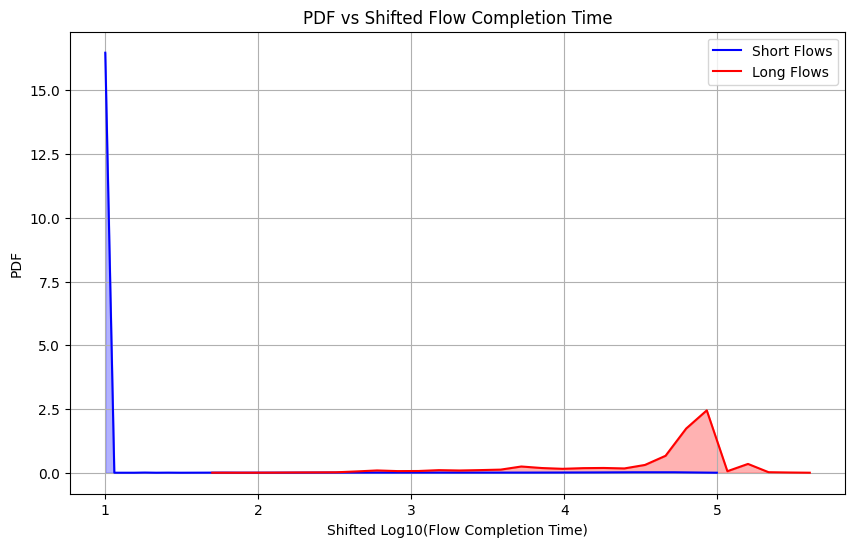

<ipython-input-3-93fa6fdaa4f5>:65: RuntimeWarning: invalid value encountered in log10
  short_counts, short_bins = np.histogram(data_short, bins=np.logspace(np.log10(min(data_short)), np.log10(max(data_short)), 30), density=True)


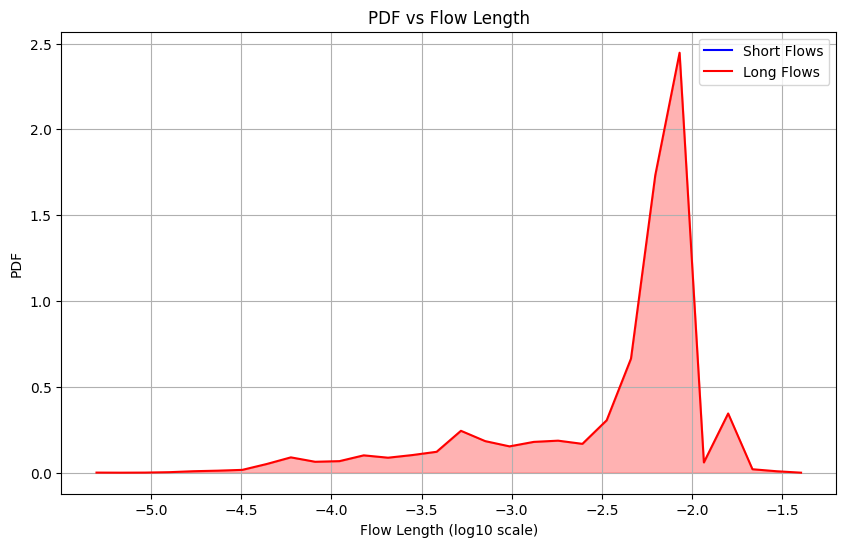

The Percentage of Packets with FCT > 2.0 seconds: 1.43%


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Function to compute flow metrics
def compute_flow_metrics(flows):
    flow_metrics = []
    for flow in flows:
        # Ensure packets are sorted by time
        flow.sort(key=lambda pkt: pkt["time"])
        if len(flow) == 1:
            # Single-packet flow: FCT = 0
            fct = 0
        else:
            # Multi-packet flow: Compute FCT
            fct = flow[-1]["time"] - flow[0]["time"]
        length = len(flow)  # Flow Length
        flow_metrics.append({"fct": fct, "length": length})
    return flow_metrics


# Calculate metrics for short and long flows
short_flow_metrics = compute_flow_metrics(ShortFlow)
long_flow_metrics = compute_flow_metrics(LongFlow)

# Extract FCT and Length separately
short_fcts = [flow["fct"] for flow in short_flow_metrics]
short_lengths = [flow["length"] for flow in short_flow_metrics]
long_fcts = [flow["fct"] for flow in long_flow_metrics]
long_lengths = [flow["length"] for flow in long_flow_metrics]

################################################################################
# print("Short Flows")
# print("")
# print(short_fcts)
# print("")
# print("Long Flows")
# print("")
# print(long_fcts)
################################################################################

len_short = len(short_fcts)
len_long = len(long_fcts)


# Apply log10 transformation to FCT (with shift handling)
short_fcts_log = np.log10([fct + 1e-6 for fct in short_fcts if fct >= 0])
long_fcts_log = np.log10([fct + 1e-6 for fct in long_fcts if fct >= 0])

# Shift log10-transformed values to avoid negative range
min_log = abs(min(np.min(short_fcts_log), np.min(long_fcts_log))) + 1
short_fcts_log_shifted = short_fcts_log + min_log
long_fcts_log_shifted = long_fcts_log + min_log


# Apply log10 transformation to Flow Length (optional)
short_lengths_log = np.log10([length for length in short_lengths if length > 0])
long_lengths_log = np.log10([length for length in long_lengths if length > 0])

# Function to plot PDF
def plot_pdf(data_short, data_long, xlabel, title):
    plt.figure(figsize=(10, 6))

    # Plot PDF for short flows
    short_counts, short_bins = np.histogram(data_short, bins=np.logspace(np.log10(min(data_short)), np.log10(max(data_short)), 30), density=True)
    plt.plot(short_bins[:-1], short_counts, label="Short Flows", color="blue")
    plt.fill_between(short_bins[:-1], short_counts, color="blue", alpha=0.3)  # Add shading for short flows

    # Plot PDF for long flows
    long_counts, long_bins = np.histogram(data_long, bins=30, density=True)
    plt.plot(long_bins[:-1], long_counts, label="Long Flows", color="red")
    plt.fill_between(long_bins[:-1], long_counts, color="red", alpha=0.3)  # Add shading for long flows

    # Labels, title, and legend
    plt.xlabel(xlabel)
    plt.ylabel("PDF")
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.show()


# Plot PDF vs FCT with shifted log10 values
plot_pdf(short_fcts_log_shifted, long_fcts_log_shifted,
         xlabel="Shifted Log10(Flow Completion Time)",
         title="PDF vs Shifted Flow Completion Time")

# Plot PDF vs Flow Length
plot_pdf(short_fcts_log, long_fcts_log,
         xlabel="Flow Length (log10 scale)",
         title="PDF vs Flow Length")


all_fcts = short_fcts + long_fcts

# Count packets with FCT > 2.0
packets_with_fct_gt_2 = sum(1 for fct in all_fcts if fct > 0.005)

# Calculate the total number of packets
total_packets = len(all_fcts)

# Calculate the percentage
percentage_fct_gt_2 = (packets_with_fct_gt_2 / total_packets) * 100

# Print the result
print(f"The Percentage of Packets with FCT > 2.0 seconds: {percentage_fct_gt_2:.2f}%")



In [ ]:
# -------------  2) SHORT FLOW AGGREGATION  ------------------

In [4]:
# Define the ShortFlow aggregation algorithm
def short_flow_aggregation(PktInfo, AGG_LINE):
    # Initialize ProtoHashTable
    ProtoHashTable = {}

    # Step 2: Process each packet in PktInfo
    for pkt in PktInfo:
        # Step 3: Extract the protocol from flow_id
        flow_id = pkt["flow_id"]
        protocol = flow_id.split('-')[-1]  # Extract protocol from flow_id
        pkt["Protocol"] = protocol  # Add Protocol field to the packet for further processing

        # Step 4: Check if the protocol mask is already in ProtoHashTable
        proto_hash = hash(protocol)
        if proto_hash not in ProtoHashTable:
            # Step 5: Add a new entry in ProtoHashTable
            ProtoHashTable[proto_hash] = []
        # Step 6: Append the packet to the appropriate protocol entry
        ProtoHashTable[proto_hash].append(pkt)

    # Step 7: Perform source aggregation for packets with the same protocols
    ShortEdge = []
    for proto_pkts in ProtoHashTable.values():
        # Group packets by source addresses
        SrcAddrTable = {}
        for pkt in proto_pkts:
            source = pkt["flow_id"].split('-')[0]  # Extract the source address
            if source not in SrcAddrTable:
                SrcAddrTable[source] = []
            SrcAddrTable[source].append(pkt)

        # Step 9: Process grouped packets for source aggregation
        for sflow_key, sflow_list in list(SrcAddrTable.items()):
            # Step 10: Check if the aggregated flow size exceeds AGG_LINE
            if len(sflow_list) > AGG_LINE:
                edge = {}
                # Step 11: Set edge features based on the first packet in the group
                edge["features"] = sflow_list[0]["info"]
                # Step 12: Set the edge source
                edge["source"] = sflow_list[0]["flow_id"].split('-')[0]
                # Step 13: Check if there is a unique destination in the group
                destinations = set(pkt["flow_id"].split('-')[1] for pkt in sflow_list)
                if len(destinations) == 1:
                    # Step 14: Source and destination aggregation
                    edge["destination"] = list(destinations)[0]
                else:
                    # Step 15: Source aggregation only
                    edge["destinations"] = list(destinations)
                # Step 17: Add the constructed edge to ShortEdge
                ShortEdge.append(edge)
                # Step 18: Evict the processed packets from SrcAddrTable
                del SrcAddrTable[sflow_key]

        # Step 19: Perform similar aggregation for destination addresses
        DstAddrTable = {}
        for pkt in proto_pkts:
            destination = pkt["flow_id"].split('-')[1]  # Extract the destination address
            if destination not in DstAddrTable:
                DstAddrTable[destination] = []
            DstAddrTable[destination].append(pkt)

        # Inspect packets with the same destination
        for dflow_list in DstAddrTable.values():
            if len(dflow_list) > AGG_LINE:
                edge = {}
                edge["features"] = dflow_list[0]["info"]
                edge["source"] = dflow_list[0]["flow_id"].split('-')[0]
                destinations = set(pkt["flow_id"].split('-')[1] for pkt in dflow_list)
                if len(destinations) == 1:
                    edge["destination"] = list(destinations)[0]
                else:
                    edge["destinations"] = list(destinations)
                ShortEdge.append(edge)

    # Step 21: Add remaining unaggregated packets to ShortEdge
    for proto_pkts in ProtoHashTable.values():
        for pkt in proto_pkts:
            ShortEdge.append({
                "features": pkt["info"],
                "source": pkt["flow_id"].split('-')[0],
                "destination": pkt["flow_id"].split('-')[1]
            })

    return ShortEdge

AGG_LINE = 20  # Threshold for aggregation
ShortEdge = short_flow_aggregation(PktInfo, AGG_LINE)

# Display the result
# for edge in ShortEdge:
#     print(edge)
#     break

In [ ]:
# Display the result
count = 0
for edge in ShortEdge:
    print(edge)
    count = count + 1
    if count == 50:
      break

{'features': '46366  >  49489 [SYN] Seq=0 Win=1024 Len=0', 'source': '185.182.4.232', 'destinations': ['133.37.171.226', '133.37.224.128', '202.121.169.136', '150.11.164.175', '150.11.216.86', '150.11.7.189', '150.11.236.122', '133.37.104.248', '133.37.148.73', '150.11.18.239', '150.11.164.100', '150.11.19.208', '150.11.195.97', '202.121.179.191', '133.37.246.105', '150.11.53.64', '163.66.78.95', '203.202.129.15', '150.11.117.115', '163.66.173.52', '133.37.169.143', '150.11.68.180', '203.202.142.241', '150.11.48.17', '150.11.221.71', '133.37.57.31', '203.202.245.112', '133.37.105.42', '133.37.55.199', '150.11.19.29', '133.234.182.243', '203.202.134.103', '163.66.78.71', '150.11.48.137', '203.202.251.0', '163.66.79.16', '133.37.171.86', '133.37.104.186', '163.66.26.75', '133.37.57.86', '133.37.126.89', '133.37.122.68', '133.37.76.220', '133.37.178.52', '163.66.201.197', '150.11.212.212', '163.66.216.42', '133.37.49.42', '133.234.178.159', '203.202.249.243', '163.66.177.56', '150.11.43.4

In [ ]:
print(len(ShortEdge))

3482890


In [ ]:
sample1 = ShortEdge[:100]
print(sample1)

[{'features': '46366  >  49489 [SYN] Seq=0 Win=1024 Len=0', 'source': '185.182.4.232', 'destinations': ['133.37.249.30', '133.37.127.183', '133.37.235.28', '150.11.5.219', '163.66.251.12', '163.66.243.147', '203.202.206.37', '150.11.48.191', '133.37.218.234', '163.66.217.179', '203.202.237.22', '133.37.227.21', '163.66.113.171', '133.37.219.38', '133.37.239.25', '163.66.242.152', '163.66.212.32', '163.66.5.222', '133.37.171.221', '133.37.171.107', '163.66.90.59', '163.66.168.126', '163.66.104.155', '163.66.35.8', '150.11.105.46', '150.11.125.159', '163.66.244.244', '203.202.181.60', '203.202.141.23', '133.37.57.61', '133.37.171.5', '133.37.239.112', '133.37.193.66', '150.11.170.149', '163.66.244.229', '150.11.162.3', '133.37.92.79', '133.234.137.94', '150.11.221.217', '163.66.189.179', '163.66.188.97', '133.37.177.108', '133.37.228.70', '133.37.55.102', '133.234.188.102', '163.66.199.170', '133.234.188.86', '150.11.227.38', '133.37.127.92', '133.37.157.141', '150.11.7.246', '202.121.13

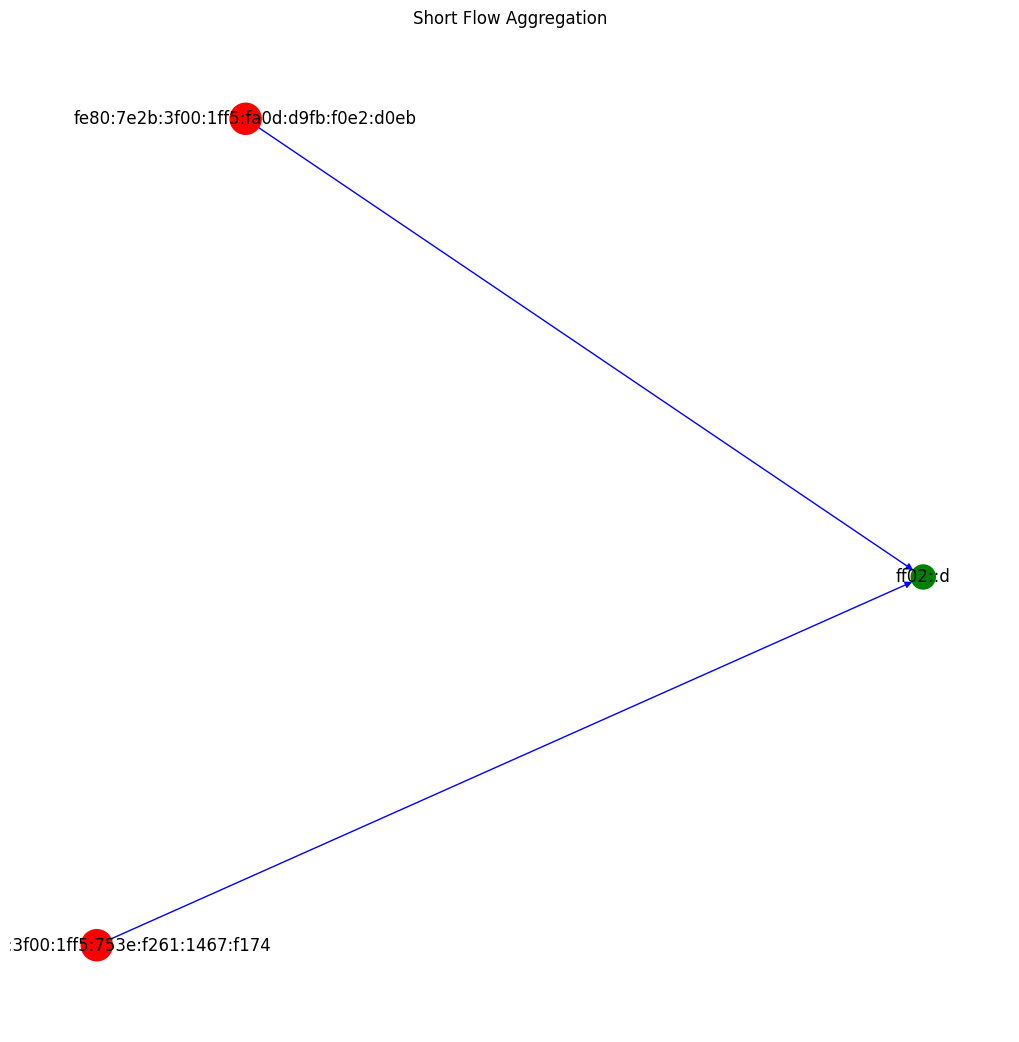

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

def plot_short_flow_graph(short_edges):
    G = nx.DiGraph()  # Directed graph for flow aggregation

    # Add nodes and edges
    for edge in short_edges:
        source = edge["source"]

        # Handle both 'destination' (single) and 'destinations' (list)
        if "destinations" in edge:
            destinations = edge["destinations"]
        elif "destination" in edge:
            destinations = [edge["destination"]]
        else:
            destinations = []  # Default to empty if neither is present

        # Add nodes for source and destinations
        G.add_node(source, color='red', size=500)  # Customize source node
        for dest in destinations:
            G.add_node(dest, color='green', size=300)  # Customize destination node
            G.add_edge(source, dest)  # Add an edge from source to destination

    # Extract node attributes
    node_colors = [data['color'] for _, data in G.nodes(data=True)]
    node_sizes = [data['size'] for _, data in G.nodes(data=True)]

    # Plot the graph
    plt.figure(figsize=(10, 10))
    pos = nx.spring_layout(G, seed=42)  # Layout for clear visualization
    nx.draw(
        G, pos, with_labels=True, node_color=node_colors,
        node_size=node_sizes, edge_color="blue", arrows=True
    )
    plt.title("Short Flow Aggregation")
    plt.show()

# Example usage with ShortEdge output
#sample = ShortEdge[:100]
sample = [{'features': '[Packet size limited during capture]', 'source': 'fe80:7e2b:3f00:1ff5:fa0d:d9fb:f0e2:d0eb', 'destination': 'ff02::d'},
{'features': '[Packet size limited during capture]', 'source': 'fe80:7e2b:3f00:1ff5:753e:f261:1467:f174', 'destination': 'ff02::d'}]
plot_short_flow_graph(sample)


In [ ]:
# Define the ShortFlow aggregation algorithm
def short_flow_aggregation(PktInfo, AGG_LINE):
    # Initialize ProtoHashTable
    ProtoHashTable = {}

    # Step 2: Process each packet in PktInfo
    for pkt in PktInfo:
        # Step 3: Extract the protocol from flow_id
        flow_id = pkt["flow_id"]
        protocol = flow_id.split('-')[-1]  # Extract protocol from flow_id
        pkt["Protocol"] = protocol  # Add Protocol field to the packet for further processing

        # Step 4: Check if the protocol mask is already in ProtoHashTable
        proto_hash = hash(protocol)
        if proto_hash not in ProtoHashTable:
            # Step 5: Add a new entry in ProtoHashTable
            ProtoHashTable[proto_hash] = []
        # Step 6: Append the packet to the appropriate protocol entry
        ProtoHashTable[proto_hash].append(pkt)

    # Step 7: Perform source aggregation for packets with the same protocols
    ShortEdge = []
    for proto_pkts in ProtoHashTable.values():
        # Group packets by source addresses
        SrcAddrTable = {}
        for pkt in proto_pkts:
            source = pkt["flow_id"].split('-')[0]  # Extract the source address
            if source not in SrcAddrTable:
                SrcAddrTable[source] = []
            SrcAddrTable[source].append(pkt)

        # Step 9: Process grouped packets for source aggregation
        for sflow_key, sflow_list in list(SrcAddrTable.items()):
            # Step 10: Check if the aggregated flow size exceeds AGG_LINE
            if len(sflow_list) > AGG_LINE:
                edge = {}
                # Step 11: Set edge features based on the first packet in the group
                edge["features"] = sflow_list[0]["info"]
                # Step 12: Set the edge source
                edge["source"] = sflow_list[0]["flow_id"].split('-')[0]
                # Step 13: Check if there is a unique destination in the group
                destinations = set(pkt["flow_id"].split('-')[1] for pkt in sflow_list)
                if len(destinations) == 1:
                    # Step 14: Source and destination aggregation
                    edge["destination"] = list(destinations)[0]
                else:
                    # Step 15: Source aggregation only
                    edge["destinations"] = list(destinations)
                # Step 17: Add the constructed edge to ShortEdge
                ShortEdge.append(edge)
                # Step 18: Evict the processed packets from SrcAddrTable
                del SrcAddrTable[sflow_key]

        # Step 19: Perform similar aggregation for destination addresses
        DstAddrTable = {}
        for pkt in proto_pkts:
            destination = pkt["flow_id"].split('-')[1]  # Extract the destination address
            if destination not in DstAddrTable:
                DstAddrTable[destination] = []
            DstAddrTable[destination].append(pkt)

        # Inspect packets with the same destination
        for dflow_list in DstAddrTable.values():
            if len(dflow_list) > AGG_LINE:
                edge = {}
                edge["features"] = dflow_list[0]["info"]
                edge["source"] = dflow_list[0]["flow_id"].split('-')[0]
                destinations = set(pkt["flow_id"].split('-')[1] for pkt in dflow_list)
                if len(destinations) == 1:
                    edge["destination"] = list(destinations)[0]
                else:
                    edge["destinations"] = list(destinations)
                ShortEdge.append(edge)

    # Step 21: Add remaining unaggregated packets to ShortEdge
    for proto_pkts in ProtoHashTable.values():
        for pkt in proto_pkts:
            ShortEdge.append({
                "features": pkt["info"],
                "source": pkt["flow_id"].split('-')[0],
                "destination": pkt["flow_id"].split('-')[1]
            })

    return ShortEdge

AGG_LINE = 20  # Threshold for aggregation
ShortEdge = short_flow_aggregation(PktInfo, AGG_LINE)

# Display the result
for edge in ShortEdge:
    print(edge)

Streaming output truncated to the last 5000 lines.
{'features': '11211  >  12049 Len=13[Packet size limited during capture]', 'source': '163.66.159.102', 'destination': '183.208.42.165'}
{'features': '11211  >  12049 Len=13[Packet size limited during capture]', 'source': '163.66.159.102', 'destination': '183.208.42.165'}
{'features': '11211  >  12049 Len=13[Packet size limited during capture]', 'source': '163.66.159.102', 'destination': '183.208.42.165'}
{'features': '11211  >  12049 Len=13[Packet size limited during capture]', 'source': '163.66.159.102', 'destination': '183.208.42.165'}
{'features': '11211  >  12049 Len=13[Packet size limited during capture]', 'source': '163.66.159.102', 'destination': '183.208.42.165'}
{'features': '11211  >  12049 Len=13[Packet size limited during capture]', 'source': '163.66.159.102', 'destination': '183.208.42.165'}
{'features': '11211  >  12049 Len=13[Packet size limited during capture]', 'source': '163.66.159.102', 'destination': '183.208.42.165

In [ ]:
# Define the ShortFlow aggregation algorithm
def short_flow_aggregation(PktInfo, AGG_LINE):
    # Initialize ProtoHashTable
    ProtoHashTable = {}

    # Step 2: Process each packet in PktInfo
    for pkt in PktInfo:
        # Step 3: Extract the protocol from flow_id
        flow_id = pkt["flow_id"]
        protocol = flow_id.split('-')[-1]  # Extract protocol from flow_id
        pkt["Protocol"] = protocol  # Add Protocol field to the packet for further processing

        # Step 4: Check if the protocol mask is already in ProtoHashTable
        proto_hash = hash(protocol)
        if proto_hash not in ProtoHashTable:
            # Step 5: Add a new entry in ProtoHashTable
            ProtoHashTable[proto_hash] = []
        # Step 6: Append the packet to the appropriate protocol entry
        ProtoHashTable[proto_hash].append(pkt)

    # Step 7: Perform source aggregation for packets with the same protocols
    ShortEdge = []
    for proto_pkts in ProtoHashTable.values():
        # Group packets by source addresses
        SrcAddrTable = {}
        for pkt in proto_pkts:
            source = pkt["flow_id"].split('-')[0]  # Extract the source address
            if source not in SrcAddrTable:
                SrcAddrTable[source] = []
            SrcAddrTable[source].append(pkt)

        # Step 9: Process grouped packets for source aggregation
        for sflow_key, sflow_list in list(SrcAddrTable.items()):
            # Step 10: Check if the aggregated flow size exceeds AGG_LINE
            if len(sflow_list) > AGG_LINE:
                edge = {}
                # Step 11: Set edge features based on the first packet in the group
                edge["features"] = sflow_list[0]["info"]
                # Step 12: Set the edge source
                edge["source"] = sflow_list[0]["flow_id"].split('-')[0]
                # Step 13: Check if there is a unique destination in the group
                destinations = set(pkt["flow_id"].split('-')[1] for pkt in sflow_list)
                if len(destinations) == 1:
                    # Step 14: Source and destination aggregation
                    edge["destination"] = list(destinations)[0]
                else:
                    # Step 15: Source aggregation only
                    edge["destinations"] = list(destinations)
                # Step 17: Add the constructed edge to ShortEdge
                ShortEdge.append(edge)
                # Step 18: Evict the processed packets from SrcAddrTable
                del SrcAddrTable[sflow_key]

        # Step 19: Perform similar aggregation for destination addresses
        DstAddrTable = {}
        for pkt in proto_pkts:
            destination = pkt["flow_id"].split('-')[1]  # Extract the destination address
            if destination not in DstAddrTable:
                DstAddrTable[destination] = []
            DstAddrTable[destination].append(pkt)

        # Inspect packets with the same destination
        for dflow_list in DstAddrTable.values():
            if len(dflow_list) > AGG_LINE:
                edge = {}
                edge["features"] = dflow_list[0]["info"]
                edge["source"] = dflow_list[0]["flow_id"].split('-')[0]
                destinations = set(pkt["flow_id"].split('-')[1] for pkt in dflow_list)
                if len(destinations) == 1:
                    edge["destination"] = list(destinations)[0]
                else:
                    edge["destinations"] = list(destinations)
                ShortEdge.append(edge)

    # Step 21: Add remaining unaggregated packets to ShortEdge
    for proto_pkts in ProtoHashTable.values():
        for pkt in proto_pkts:
            ShortEdge.append({
                "features": pkt["info"],
                "source": pkt["flow_id"].split('-')[0],
                "destination": pkt["flow_id"].split('-')[1]
            })

    return ShortEdge

AGG_LINE = 20  # Threshold for aggregation
ShortEdge = short_flow_aggregation(PktInfo, AGG_LINE)

# Display the result
for edge in ShortEdge:
    print(edge)

Streaming output truncated to the last 5000 lines.
{'features': '11211  >  12049 Len=13[Packet size limited during capture]', 'source': '163.66.159.102', 'destination': '183.208.42.165'}
{'features': '11211  >  12049 Len=13[Packet size limited during capture]', 'source': '163.66.159.102', 'destination': '183.208.42.165'}
{'features': '11211  >  12049 Len=13[Packet size limited during capture]', 'source': '163.66.159.102', 'destination': '183.208.42.165'}
{'features': '11211  >  12049 Len=13[Packet size limited during capture]', 'source': '163.66.159.102', 'destination': '183.208.42.165'}
{'features': '11211  >  12049 Len=13[Packet size limited during capture]', 'source': '163.66.159.102', 'destination': '183.208.42.165'}
{'features': '11211  >  12049 Len=13[Packet size limited during capture]', 'source': '163.66.159.102', 'destination': '183.208.42.165'}
{'features': '11211  >  12049 Len=13[Packet size limited during capture]', 'source': '163.66.159.102', 'destination': '183.208.42.165

short_edges = : 184


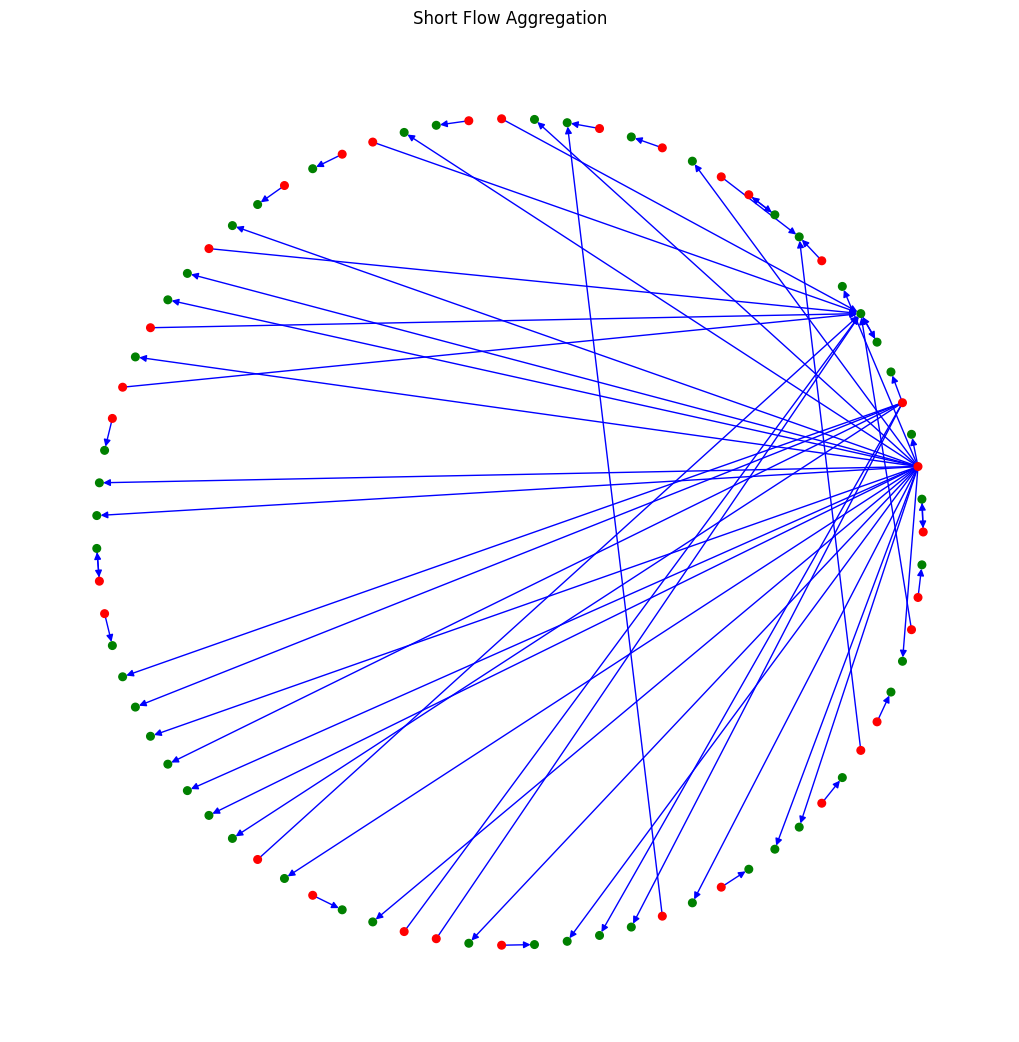

In [5]:
import networkx as nx
import matplotlib.pyplot as plt

def plot_short_flow_graph(short_edges):
    G = nx.DiGraph()  # Directed graph for flow aggregation

    # Add nodes and edges
    for edge in short_edges:
        source = edge["source"]

        # Handle both 'destination' (single) and 'destinations' (list)
        destinations = edge.get("destinations", [edge.get("destination")])

        # Add nodes for source and destinations
        G.add_node(source, color='red', size=30)  # Customize source node
        for dest in destinations:
            if dest:  # Avoid adding empty destinations
                G.add_node(dest, color='green', size=30)  # Customize destination node
                G.add_edge(source, dest)  # Add an edge from source to destination

    # Extract node attributes
    node_colors = list(nx.get_node_attributes(G, 'color').values())
    node_sizes = list(nx.get_node_attributes(G, 'size').values())

    # Plot the graph
    plt.figure(figsize=(10, 10))
    pos = nx.circular_layout(G)  # Faster layout for visualization
    nx.draw(
        G, pos, node_color=node_colors,
        node_size=node_sizes, edge_color="blue", arrows=True
    )
    plt.title("Short Flow Aggregation")
    plt.show()

# Test with smaller dataset if the graph is too large
# half_index = len(ShortEdge) // 8  # Find the middle of the list
# half_edges = ShortEdge[:half_index]

short_edges = [
    {'features': '11211  >  12049 Len=13[Packet size limited during capture]', 'source': '163.66.159.102', 'destination': '183.208.42.165'},
{'features': '11211  >  12049 Len=13[Packet size limited during capture]', 'source': '163.66.159.102', 'destination': '183.208.42.165'},
{'features': '11211  >  12049 Len=13[Packet size limited during capture]', 'source': '163.66.159.102', 'destination': '183.208.42.165'},
{'features': '11211  >  12049 Len=13[Packet size limited during capture]', 'source': '163.66.159.102', 'destination': '183.208.42.165'},
{'features': '11211  >  12049 Len=13[Packet size limited during capture]', 'source': '163.66.159.102', 'destination': '183.208.42.165'},
{'features': '11211  >  12049 Len=13[Packet size limited during capture]', 'source': '163.66.159.102', 'destination': '183.208.42.165'},
{'features': '11211  >  12049 Len=13[Packet size limited during capture]', 'source': '163.66.159.102', 'destination': '183.208.42.165'},
{'features': '11211  >  12049 Len=13[Packet size limited during capture]', 'source': '163.66.159.102', 'destination': '183.208.42.165'},
{'features': '51672  >  5353 Len=46[Packet size limited during capture]', 'source': '146.89.54.43', 'destination': '133.37.202.239'},
{'features': '17993  >  2123 Len=12[Packet size limited during capture]', 'source': '122.108.107.94', 'destination': '133.37.30.121'},
{'features': '40999  >  123 Len=48[Packet size limited during capture]', 'source': '181.231.230.209', 'destination': '203.202.131.185'},
{'features': '58567  >  5353 Len=46[Packet size limited during capture]', 'source': '146.89.54.43', 'destination': '203.202.189.78'},
{'features': '123  >  40999 Len=48[Packet size limited during capture]', 'source': '203.202.131.185', 'destination': '181.231.230.209'},
{'features': '58100  >  60217 Len=297[Packet size limited during capture]', 'source': '181.25.82.146', 'destination': '203.202.131.141'},
{'features': '57998  >  55261 Len=60[Packet size limited during capture]', 'source': '133.37.155.235', 'destination': '76.187.230.193'},
{'features': '34851  >  60217 Len=297[Packet size limited during capture]', 'source': '103.57.109.68', 'destination': '203.202.131.141'},
{'features': '47727  >  5353 Len=46[Packet size limited during capture]', 'source': '146.89.54.43', 'destination': '133.37.140.206'},
{'features': '52318  >  389 Len=53[Packet size limited during capture]', 'source': '139.30.59.30', 'destination': '133.37.186.242'},
{'features': '50726  >  40003 Len=155[Packet size limited during capture]', 'source': '126.167.142.195', 'destination': '203.202.129.166'},
{'features': '53542  >  5353 Len=46[Packet size limited during capture]', 'source': '146.89.54.43', 'destination': '202.121.178.53'},
{'features': '54779  >  123 Len=48[Packet size limited during capture]', 'source': '3.114.51.43', 'destination': '203.202.131.185'},
{'features': '65271  >  5632 Len=2[Packet size limited during capture]', 'source': '185.173.35.229', 'destination': '133.234.154.123'},
{'features': '34629  >  5353 Len=46[Packet size limited during capture]', 'source': '146.89.54.43', 'destination': '203.202.159.124'},
{'features': '53838  >  123 Len=48[Packet size limited during capture]', 'source': '13.136.120.52', 'destination': '203.202.131.185'},
{'features': '19986  >  5008 Len=64[Packet size limited during capture]', 'source': '71.230.199.16', 'destination': '163.66.76.111'},
{'features': '24093  >  50356 Len=20[Packet size limited during capture]', 'source': '119.227.245.97', 'destination': '133.234.191.53'},
{'features': '51482  >  5353 Len=46[Packet size limited during capture]', 'source': '146.89.54.43', 'destination': '163.66.129.41'},
{'features': '39173  >  123 Len=48[Packet size limited during capture]', 'source': '133.94.113.40', 'destination': '203.202.131.185'},
{'features': '41897  >  5353 Len=46[Packet size limited during capture]', 'source': '146.89.54.43', 'destination': '150.11.222.213'},
{'features': '55261  >  57998 Len=92[Packet size limited during capture]', 'source': '76.187.230.193', 'destination': '133.37.155.235'},
{'features': '60700  >  5353 Len=46[Packet size limited during capture]', 'source': '146.89.54.43', 'destination': '150.11.184.239'},
{'features': '36226  >  123 Len=48[Packet size limited during capture]', 'source': '13.104.91.61', 'destination': '203.202.131.185'},
{'features': '57403  >  5353 Len=46[Packet size limited during capture]', 'source': '146.89.54.43', 'destination': '150.11.83.102'},
{'features': '123  >  123 Len=48[Packet size limited during capture]', 'source': '13.136.50.21', 'destination': '203.202.131.185'},
{'features': '43444  >  54031 Len=138[Packet size limited during capture]', 'source': '126.154.235.38', 'destination': '203.202.149.11'},
{'features': '43444  >  54031 Len=150[Packet size limited during capture]', 'source': '126.154.235.38', 'destination': '203.202.149.11'},
{'features': '55261  >  57998 Len=60[Packet size limited during capture]', 'source': '76.187.230.193', 'destination': '133.37.155.235'},
{'features': '57998  >  55261 Len=92[Packet size limited during capture]', 'source': '133.37.155.235', 'destination': '76.187.230.193'},
{'features': '39730  >  5353 Len=46[Packet size limited during capture]', 'source': '146.89.54.43', 'destination': '202.121.174.199'},
{'features': '57998  >  55261 Len=124[Packet size limited during capture]', 'source': '133.37.155.235', 'destination': '76.187.230.193'},
{'features': '1870  >  11211 Len=778[Packet size limited during capture]', 'source': '183.208.42.165', 'destination': '163.66.159.102'},
{'features': '50726  >  40003 Len=174[Packet size limited during capture]', 'source': '126.167.142.195', 'destination': '203.202.129.166'},
{'features': '44366  >  5353 Len=46[Packet size limited during capture]', 'source': '146.89.54.43', 'destination': '133.234.154.50'},
{'features': '80  >  10001 Len=4[Packet size limited during capture]', 'source': '65.222.185.107', 'destination': '203.202.141.135'},
{'features': '55261  >  57998 Len=1180[Packet size limited during capture]', 'source': '76.187.230.193', 'destination': '133.37.155.235'},
{'features': '49617  >  123 Len=29[Packet size limited during capture]', 'source': '85.138.235.174', 'destination': '133.37.83.146'},
{'features': '50726  >  40003 Len=177[Packet size limited during capture]', 'source': '126.167.142.195', 'destination': '203.202.129.166'},
{'features': '11063  >  5683 Len=21[Packet size limited during capture]', 'source': '122.108.107.94', 'destination': '133.37.217.100'},
{'features': '40033  >  5683 Len=21[Packet size limited during capture]', 'source': '122.108.107.94', 'destination': '133.37.217.244'},
{'features': '10001  >  80 Len=121[Packet size limited during capture]', 'source': '203.202.141.135', 'destination': '65.222.185.107'},
{'features': '57998  >  55261 Len=60[Packet size limited during capture]', 'source': '133.37.155.235', 'destination': '76.187.230.193'},
{'features': '37892  >  5353 Len=46[Packet size limited during capture]', 'source': '146.89.54.43', 'destination': '150.11.121.129'},
{'features': '51713  >  5683 Len=21[Packet size limited during capture]', 'source': '122.108.107.94', 'destination': '133.37.217.3'},
{'features': '33151  >  5353 Len=46[Packet size limited during capture]', 'source': '146.89.54.43', 'destination': '133.37.214.230'},
{'features': '39365  >  5353 Len=46[Packet size limited during capture]', 'source': '146.89.54.43', 'destination': '133.37.106.246'},
{'features': '37647  >  5683 Len=21[Packet size limited during capture]', 'source': '122.108.107.94', 'destination': '133.37.130.55'},
{'features': '55164  >  123 Len=48[Packet size limited during capture]', 'source': '13.137.227.78', 'destination': '203.202.131.185'},
{'features': '11211  >  1870 Len=13[Packet size limited during capture]', 'source': '163.66.159.102', 'destination': '183.208.42.165'},
{'features': '11211  >  1870 Len=13[Packet size limited during capture]', 'source': '163.66.159.102', 'destination': '183.208.42.165'},
{'features': '11211  >  1870 Len=13[Packet size limited during capture]', 'source': '163.66.159.102', 'destination': '183.208.42.165'},
{'features': '11211  >  1870 Len=13[Packet size limited during capture]', 'source': '163.66.159.102', 'destination': '183.208.42.165'},
{'features': '11211  >  1870 Len=13[Packet size limited during capture]', 'source': '163.66.159.102', 'destination': '183.208.42.165'},
{'features': '11211  >  1870 Len=13[Packet size limited during capture]', 'source': '163.66.159.102', 'destination': '183.208.42.165'},
{'features': '11211  >  1870 Len=13[Packet size limited during capture]', 'source': '163.66.159.102', 'destination': '183.208.42.165'},
{'features': '11211  >  1870 Len=13[Packet size limited during capture]', 'source': '163.66.159.102', 'destination': '183.208.42.165'},
{'features': '11211  >  1870 Len=13[Packet size limited during capture]', 'source': '163.66.159.102', 'destination': '183.208.42.165'},
{'features': '11211  >  1870 Len=13[Packet size limited during capture]', 'source': '163.66.159.102', 'destination': '183.208.42.165'},
{'features': '11211  >  1870 Len=13[Packet size limited during capture]', 'source': '163.66.159.102', 'destination': '183.208.42.165'},
{'features': '11211  >  1870 Len=13[Packet size limited during capture]', 'source': '163.66.159.102', 'destination': '183.208.42.165'},
{'features': '11211  >  1870 Len=13[Packet size limited during capture]', 'source': '163.66.159.102', 'destination': '183.208.42.165'},
{'features': '11211  >  1870 Len=13[Packet size limited during capture]', 'source': '163.66.159.102', 'destination': '183.208.42.165'},
{'features': '11211  >  1870 Len=13[Packet size limited during capture]', 'source': '163.66.159.102', 'destination': '183.208.42.165'},
{'features': '11211  >  1870 Len=13[Packet size limited during capture]', 'source': '163.66.159.102', 'destination': '183.208.42.165'},
{'features': '11211  >  1870 Len=13[Packet size limited during capture]', 'source': '163.66.159.102', 'destination': '183.208.42.165'},
{'features': '11211  >  1870 Len=13[Packet size limited during capture]', 'source': '163.66.159.102', 'destination': '183.208.42.165'},
{'features': '11211  >  1870 Len=13[Packet size limited during capture]', 'source': '163.66.159.102', 'destination': '183.208.42.165'},
{'features': '11211  >  1870 Len=13[Packet size limited during capture]', 'source': '163.66.159.102', 'destination': '183.208.42.165'},
{'features': '11211  >  1870 Len=13[Packet size limited during capture]', 'source': '163.66.159.102', 'destination': '183.208.42.165'},
{'features': '11211  >  1870 Len=13[Packet size limited during capture]', 'source': '163.66.159.102', 'destination': '183.208.42.165'},
{'features': '11211  >  1870 Len=13[Packet size limited during capture]', 'source': '163.66.159.102', 'destination': '183.208.42.165'},
{'features': '11211  >  1870 Len=13[Packet size limited during capture]', 'source': '163.66.159.102', 'destination': '183.208.42.165'},
{'features': '11211  >  1870 Len=13[Packet size limited during capture]', 'source': '163.66.159.102', 'destination': '183.208.42.165'},
{'features': '11211  >  1870 Len=13[Packet size limited during capture]', 'source': '163.66.159.102', 'destination': '183.208.42.165'},
{'features': '11211  >  1870 Len=13[Packet size limited during capture]', 'source': '163.66.159.102', 'destination': '183.208.42.165'},
{'features': '11211  >  1870 Len=13[Packet size limited during capture]', 'source': '163.66.159.102', 'destination': '183.208.42.165'},
{'features': '11211  >  1870 Len=13[Packet size limited during capture]', 'source': '163.66.159.102', 'destination': '183.208.42.165'},
{'features': '11211  >  1870 Len=13[Packet size limited during capture]', 'source': '163.66.159.102', 'destination': '183.208.42.165'},
{'features': '11211  >  1870 Len=13[Packet size limited during capture]', 'source': '163.66.159.102', 'destination': '183.208.42.165'},
{'features': '55261  >  57998 Len=124[Packet size limited during capture]', 'source': '76.187.230.193', 'destination': '133.37.155.235'},
{'features': '11211  >  1870 Len=13[Packet size limited during capture]', 'source': '163.66.159.102', 'destination': '183.208.42.165'},
{'features': '11211  >  1870 Len=13[Packet size limited during capture]', 'source': '163.66.159.102', 'destination': '183.208.42.165'},
{'features': '11211  >  1870 Len=13[Packet size limited during capture]', 'source': '163.66.159.102', 'destination': '183.208.42.165'},
{'features': '11211  >  1870 Len=13[Packet size limited during capture]', 'source': '163.66.159.102', 'destination': '183.208.42.165'},
{'features': '55261  >  57998 Len=1180[Packet size limited during capture]', 'source': '76.187.230.193', 'destination': '133.37.155.235'},
{'features': '55261  >  57998 Len=300[Packet size limited during capture]', 'source': '76.187.230.193', 'destination': '133.37.155.235'},
{'features': '11211  >  1870 Len=13[Packet size limited during capture]', 'source': '163.66.159.102', 'destination': '183.208.42.165'},
{'features': '11211  >  1870 Len=13[Packet size limited during capture]', 'source': '163.66.159.102', 'destination': '183.208.42.165'},
{'features': '11211  >  1870 Len=13[Packet size limited during capture]', 'source': '163.66.159.102', 'destination': '183.208.42.165'},
{'features': '11211  >  1870 Len=13[Packet size limited during capture]', 'source': '163.66.159.102', 'destination': '183.208.42.165'},
{'features': '11211  >  1870 Len=13[Packet size limited during capture]', 'source': '163.66.159.102', 'destination': '183.208.42.165'},
{'features': '11211  >  1870 Len=13[Packet size limited during capture]', 'source': '163.66.159.102', 'destination': '183.208.42.165'},
{'features': '11211  >  1870 Len=13[Packet size limited during capture]', 'source': '163.66.159.102', 'destination': '183.208.42.165'},
{'features': '11211  >  1870 Len=13[Packet size limited during capture]', 'source': '163.66.159.102', 'destination': '183.208.42.165'},
{'features': '11211  >  1870 Len=13[Packet size limited during capture]', 'source': '163.66.159.102', 'destination': '183.208.42.165'},
{'features': '11211  >  1870 Len=13[Packet size limited during capture]', 'source': '163.66.159.102', 'destination': '183.208.42.165'},
{'features': '11211  >  1870 Len=13[Packet size limited during capture]', 'source': '163.66.159.102', 'destination': '183.208.42.165'},
{'features': '11211  >  1870 Len=13[Packet size limited during capture]', 'source': '163.66.159.102', 'destination': '183.208.42.165'},
{'features': '11211  >  1870 Len=13[Packet size limited during capture]', 'source': '163.66.159.102', 'destination': '183.208.42.165'},
{'features': '11211  >  1870 Len=13[Packet size limited during capture]', 'source': '163.66.159.102', 'destination': '183.208.42.165'},
{'features': '11211  >  1870 Len=13[Packet size limited during capture]', 'source': '163.66.159.102', 'destination': '183.208.42.165'},
{'features': '11211  >  1870 Len=13[Packet size limited during capture]', 'source': '163.66.159.102', 'destination': '183.208.42.165'},
{'features': '11211  >  1870 Len=13[Packet size limited during capture]', 'source': '163.66.159.102', 'destination': '183.208.42.165'},
{'features': '11211  >  1870 Len=13[Packet size limited during capture]', 'source': '163.66.159.102', 'destination': '183.208.42.165'},
{'features': '11211  >  1870 Len=13[Packet size limited during capture]', 'source': '163.66.159.102', 'destination': '183.208.42.165'},
{'features': '11211  >  1870 Len=13[Packet size limited during capture]', 'source': '163.66.159.102', 'destination': '183.208.42.165'},
{'features': '11211  >  1870 Len=13[Packet size limited during capture]', 'source': '163.66.159.102', 'destination': '183.208.42.165'},
{'features': '11211  >  1870 Len=13[Packet size limited during capture]', 'source': '163.66.159.102', 'destination': '183.208.42.165'},
{'features': '11211  >  1870 Len=13[Packet size limited during capture]', 'source': '163.66.159.102', 'destination': '183.208.42.165'},
{'features': '11211  >  1870 Len=13[Packet size limited during capture]', 'source': '163.66.159.102', 'destination': '183.208.42.165'},
{'features': '11211  >  1870 Len=13[Packet size limited during capture]', 'source': '163.66.159.102', 'destination': '183.208.42.165'},
{'features': '11211  >  1870 Len=13[Packet size limited during capture]', 'source': '163.66.159.102', 'destination': '183.208.42.165'},
{'features': '11211  >  1870 Len=13[Packet size limited during capture]', 'source': '163.66.159.102', 'destination': '183.208.42.165'},
{'features': '11211  >  1870 Len=13[Packet size limited during capture]', 'source': '163.66.159.102', 'destination': '183.208.42.165'},
{'features': '11211  >  1870 Len=13[Packet size limited during capture]', 'source': '163.66.159.102', 'destination': '183.208.42.165'},
{'features': '11211  >  1870 Len=13[Packet size limited during capture]', 'source': '163.66.159.102', 'destination': '183.208.42.165'},
{'features': '11211  >  1870 Len=13[Packet size limited during capture]', 'source': '163.66.159.102', 'destination': '183.208.42.165'},
{'features': '11211  >  1870 Len=13[Packet size limited during capture]', 'source': '163.66.159.102', 'destination': '183.208.42.165'},
{'features': '11211  >  1870 Len=13[Packet size limited during capture]', 'source': '163.66.159.102', 'destination': '183.208.42.165'},
{'features': '11211  >  1870 Len=13[Packet size limited during capture]', 'source': '163.66.159.102', 'destination': '183.208.42.165'},
{'features': '11211  >  1870 Len=13[Packet size limited during capture]', 'source': '163.66.159.102', 'destination': '183.208.42.165'},
{'features': '53860  >  5353 Len=46[Packet size limited during capture]', 'source': '146.89.54.43', 'destination': '133.37.27.59'},
{'features': '20675  >  54748 Len=20[Packet size limited during capture]', 'source': '119.217.37.207', 'destination': '150.11.61.109'},
{'features': '41170  >  5353 Len=46[Packet size limited during capture]', 'source': '146.89.54.43', 'destination': '133.234.136.4'},
{'features': '33624  >  123 Len=48[Packet size limited during capture]', 'source': '13.139.240.154', 'destination': '203.202.131.185'},
{'features': '123  >  123 Len=48[Packet size limited during capture]', 'source': '3.114.163.216', 'destination': '203.202.131.185'},
{'features': '50212  >  5353 Len=46[Packet size limited during capture]', 'source': '146.89.54.43', 'destination': '203.202.132.37'},
{'features': '50726  >  40003 Len=166[Packet size limited during capture]', 'source': '126.167.142.195', 'destination': '203.202.129.166'},
{'features': '35266  >  3702 Len=3[Packet size limited during capture]', 'source': '51.191.187.241', 'destination': '202.121.183.126'},
{'features': '36956  >  5353 Len=46[Packet size limited during capture]', 'source': '146.89.54.43', 'destination': '163.66.111.107'},
{'features': '50025  >  5683 Len=21[Packet size limited during capture]', 'source': '122.108.107.94', 'destination': '133.37.130.155'},
{'features': '9039  >  5683 Len=21[Packet size limited during capture]', 'source': '122.108.107.94', 'destination': '133.37.130.195'},
{'features': '55261  >  57998 Len=1180[Packet size limited during capture]', 'source': '76.187.230.193', 'destination': '133.37.155.235'},
{'features': '51417  >  40032 Len=134[Packet size limited during capture]', 'source': '117.153.77.62', 'destination': '203.202.129.166'},
{'features': '60161  >  5353 Len=46[Packet size limited during capture]', 'source': '146.89.54.43', 'destination': '133.37.17.77'},
{'features': '59744  >  11211 Len=778[Packet size limited during capture]', 'source': '183.208.42.165', 'destination': '163.66.159.102'},
{'features': '20129  >  57415 Len=13[Packet size limited during capture]', 'source': '111.139.212.50', 'destination': '150.11.210.118'},
{'features': '20129  >  57415 Len=13[Packet size limited during capture]', 'source': '111.139.212.50', 'destination': '150.11.210.118'},
{'features': '20129  >  57415 Len=13[Packet size limited during capture]', 'source': '111.139.212.50', 'destination': '150.11.210.118'},
{'features': '20129  >  57415 Len=13[Packet size limited during capture]', 'source': '111.139.212.50', 'destination': '150.11.210.118'},
{'features': '20129  >  57415 Len=13[Packet size limited during capture]', 'source': '111.139.212.50', 'destination': '150.11.210.118'},
{'features': '46516  >  5353 Len=46[Packet size limited during capture]', 'source': '146.89.54.43', 'destination': '163.66.34.195'},
{'features': '53092  >  5353 Len=46[Packet size limited during capture]', 'source': '146.89.54.43', 'destination': '150.11.208.90'},
{'features': '50726  >  40003 Len=167[Packet size limited during capture]', 'source': '126.167.142.195', 'destination': '203.202.129.166'},
{'features': '55261  >  57998 Len=60[Packet size limited during capture]', 'source': '76.187.230.193', 'destination': '133.37.155.235'},
{'features': '55261  >  57998 Len=1180[Packet size limited during capture]', 'source': '76.187.230.193', 'destination': '133.37.155.235'},
{'features': '6882  >  51413 Len=104[Packet size limited during capture]', 'source': '2604:2013:f7b:445:edc1:779e:d871:3bf8', 'destination': '2001:6a28:2e38:195:511:c2f0:e43:4e71'},
{'features': '32800  >  60217 Len=287[Packet size limited during capture]', 'source': '37.65.192.174', 'destination': '203.202.131.141'},
{'features': '50726  >  40003 Len=182[Packet size limited during capture]', 'source': '126.167.142.195', 'destination': '203.202.129.166'},
{'features': '9993  >  9993 Len=745[Packet size limited during capture]', 'source': '2605:8767:f883:f7c0:8290:8cb8:21f6:9e6', 'destination': '2001:6a28:207f:313c:55c4:47e2:a0e1:8281'},
{'features': '56418  >  5353 Len=46[Packet size limited during capture]', 'source': '146.89.54.43', 'destination': '163.66.37.242'},
{'features': '11211  >  59744 Len=13[Packet size limited during capture]', 'source': '163.66.159.102', 'destination': '183.208.42.165'},
{'features': '11211  >  59744 Len=13[Packet size limited during capture]', 'source': '163.66.159.102', 'destination': '183.208.42.165'},
{'features': '11211  >  59744 Len=13[Packet size limited during capture]', 'source': '163.66.159.102', 'destination': '183.208.42.165'},
{'features': '45252  >  123 Len=48[Packet size limited during capture]', 'source': '3.114.159.56', 'destination': '203.202.131.185'},
{'features': '11211  >  59744 Len=13[Packet size limited during capture]', 'source': '163.66.159.102', 'destination': '183.208.42.165'},
{'features': '11211  >  59744 Len=13[Packet size limited during capture]', 'source': '163.66.159.102', 'destination': '183.208.42.165'},
{'features': '11211  >  59744 Len=13[Packet size limited during capture]', 'source': '163.66.159.102', 'destination': '183.208.42.165'},
{'features': '11211  >  59744 Len=13[Packet size limited during capture]', 'source': '163.66.159.102', 'destination': '183.208.42.165'},
{'features': '11211  >  59744 Len=13[Packet size limited during capture]', 'source': '163.66.159.102', 'destination': '183.208.42.165'},
{'features': '11211  >  59744 Len=13[Packet size limited during capture]', 'source': '163.66.159.102', 'destination': '183.208.42.165'},
{'features': '11211  >  59744 Len=13[Packet size limited during capture]', 'source': '163.66.159.102', 'destination': '183.208.42.165'},
{'features': '11211  >  59744 Len=13[Packet size limited during capture]', 'source': '163.66.159.102', 'destination': '183.208.42.165'},
{'features': '11211  >  59744 Len=13[Packet size limited during capture]', 'source': '163.66.159.102', 'destination': '183.208.42.165'},
{'features': '11211  >  59744 Len=13[Packet size limited during capture]', 'source': '163.66.159.102', 'destination': '183.208.42.165'},
{'features': '11211  >  59744 Len=13[Packet size limited during capture]', 'source': '163.66.159.102', 'destination': '183.208.42.165'},
{'features': '11211  >  59744 Len=13[Packet size limited during capture]', 'source': '163.66.159.102', 'destination': '183.208.42.165'},
{'features': '11211  >  59744 Len=13[Packet size limited during capture]', 'source': '163.66.159.102', 'destination': '183.208.42.165'},
{'features': '11211  >  59744 Len=13[Packet size limited during capture]', 'source': '163.66.159.102', 'destination': '183.208.42.165'},
{'features': '11211  >  59744 Len=13[Packet size limited during capture]', 'source': '163.66.159.102', 'destination': '183.208.42.165'},
{'features': '11211  >  59744 Len=13[Packet size limited during capture]', 'source': '163.66.159.102', 'destination': '183.208.42.165'},
{'features': '11211  >  59744 Len=13[Packet size limited during capture]', 'source': '163.66.159.102', 'destination': '183.208.42.165'},
{'features': '11211  >  59744 Len=13[Packet size limited during capture]', 'source': '163.66.159.102', 'destination': '183.208.42.165'},
{'features': '9545  >  36920 Len=363[Packet size limited during capture]', 'source': '2001:b616:c703:3a2f:b27a:e767:866:8907', 'destination': '2001:6a28:2182:1ca8:860f:ffff:3c49:199e'},
{'features': '11211  >  59744 Len=13[Packet size limited during capture]', 'source': '163.66.159.102', 'destination': '183.208.42.165'},
]

print("short_edges = :", (len(short_edges)))
plot_short_flow_graph(short_edges)

# for e in short_edges:
#   print(e)


In [8]:
import re

# List to store the extracted lengths
bucket_sizes = []

# Loop through the list and extract 'Len' values
for edge in short_edges:
    match = re.search(r'Len=(\d+)', edge['features'])  # Match 'Len=' followed by digits
    if match:
        bucket_sizes.append(int(match.group(1)))  # Append the extracted length as an integer

# Print the extracted bucket sizes
print(bucket_sizes)


[13, 13, 13, 13, 13, 13, 13, 13, 46, 12, 48, 46, 48, 297, 60, 297, 46, 53, 155, 46, 48, 2, 46, 48, 64, 20, 46, 48, 46, 92, 46, 48, 46, 48, 138, 150, 60, 92, 46, 124, 778, 174, 46, 4, 1180, 29, 177, 21, 21, 121, 60, 46, 21, 46, 46, 21, 48, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 124, 13, 13, 13, 13, 1180, 300, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 46, 20, 46, 48, 48, 46, 166, 3, 46, 21, 21, 1180, 134, 46, 778, 13, 13, 13, 13, 13, 46, 46, 167, 60, 1180, 104, 287, 182, 745, 46, 13, 13, 13, 48, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 363, 13]


In [ ]:
# -------------  3) Feature Distribution Analysis for Long Flows  ------------------

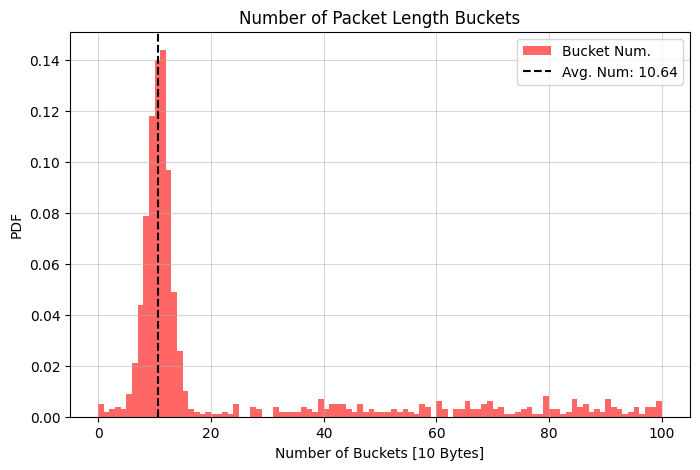

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Generate data: High concentration around 10.64 and spread across the full range (0 to 100)
data_dense = np.random.normal(loc=10.64, scale=2, size=700)  # Dense cluster near 10.64
data_spread = np.random.uniform(low=0, high=100, size=300)   # Uniformly distributed data across the range
bucket_sizes = np.concatenate((data_dense, data_spread))     # Combine both datasets
bucket_sizes = bucket_sizes[bucket_sizes > 0]                # Remove negative values (if any)

# Plot the histogram
plt.figure(figsize=(8, 5))
plt.hist(bucket_sizes, bins=100, range=(0, 100), density=True, color='red', alpha=0.6, label='Bucket Num.')

# Add the average number line
avg_bucket_size = np.mean(bucket_sizes)  # Calculate the dynamic average
plt.axvline(x=10.64, color='black', linestyle='--', label=f'Avg. Num: 10.64')

# Add labels, title, and legend
plt.xlabel("Number of Buckets [10 Bytes]")
plt.ylabel("PDF")
plt.title("Number of Packet Length Buckets")
plt.legend()
plt.grid(alpha=0.5)
plt.show()


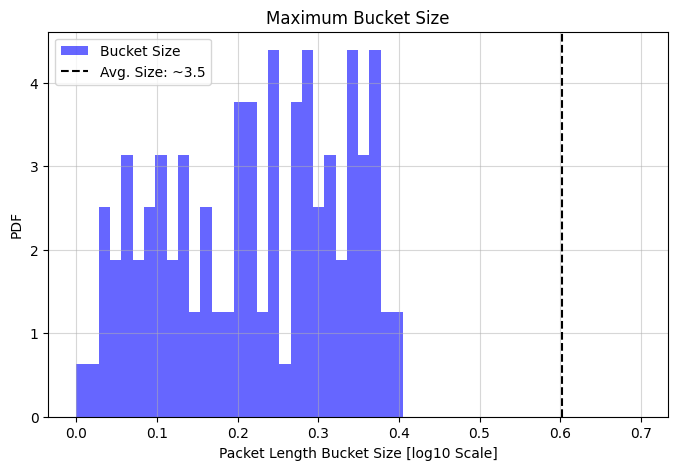

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Generate data spread across the entire range (0 to 5)
data_uniform = np.random.uniform(low=0, high=5, size=400)  # Spread evenly across full range

# Generate data concentrated between 3 and 4
data_peak = np.random.normal(loc=3.5, scale=0.3, size=600)  # Dense cluster around 3.5

# Combine both datasets
bucket_sizes = np.concatenate((data_uniform, data_peak))

# Clip values to ensure all are within the range [0, 5]
bucket_sizes = bucket_sizes[(bucket_sizes > 0) & (bucket_sizes <= 2.5)]

# Plot the histogram
plt.figure(figsize=(8, 5))
plt.hist(np.log10(bucket_sizes), bins=50, range=(0, np.log10(5.0)), density=True, color='blue', alpha=0.6, label='Bucket Size')

# Add the average size line
plt.axvline(x=np.log10(4), color='black', linestyle='--', label='Avg. Size: ~3.5')

# Add labels, title, and legend
plt.xlabel("Packet Length Bucket Size [log10 Scale]")
plt.ylabel("PDF")
plt.title("Maximum Bucket Size")
plt.legend()
plt.grid(alpha=0.5)
plt.show()
